In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments
import torch
from transformers import RobertaConfig, RobertaModel
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df_anno = pd.read_pickle('AnnoMI-full-with-audio-cleaned-text.pkl')

In [4]:
# Extract unique class names for client and therapist tasks
client_class_names = df_anno['client_talk_type'].dropna().unique().tolist()
therapist_class_names = df_anno['main_therapist_behaviour'].dropna().unique().tolist()

client_class_names, therapist_class_names

(['neutral', 'change', 'sustain'],
 ['question', 'therapist_input', 'reflection', 'other'])

In [5]:
tokenizer_twitter_sentiment = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')
tokenizer_distilbert = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_goemotion = AutoTokenizer.from_pretrained('SamLowe/roberta-base-go_emotions')
tokenizer_distilroberta_emo_base = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
tokernizer_roberta_emo_large = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-roberta-large")
tokenizer_roberta_large = AutoTokenizer.from_pretrained("roberta-large")
tokenizer_distilroberta = AutoTokenizer.from_pretrained("distilroberta-base")

In [6]:
# Tokenizer
tokenizer = tokenizer_roberta_large

# Tokenize the utterances for both tasks
def tokenize_data(texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True, return_tensors="pt")

# Client data
client_texts = df_anno[df_anno['interlocutor'] == 'client']['utterance_text']
client_labels = df_anno[df_anno['interlocutor'] == 'client']['client_talk_type'].astype("category").cat.codes
train_texts_client, val_texts_client, train_labels_client, val_labels_client = train_test_split(client_texts, client_labels, test_size=0.2, random_state=42)
train_encodings_client = tokenize_data(train_texts_client)
val_encodings_client = tokenize_data(val_texts_client)

# Therapist data
therapist_texts = df_anno[df_anno['interlocutor'] == 'therapist']['utterance_text']
therapist_labels = df_anno[df_anno['interlocutor'] == 'therapist']['main_therapist_behaviour'].astype("category").cat.codes
train_texts_therapist, val_texts_therapist, train_labels_therapist, val_labels_therapist = train_test_split(therapist_texts, therapist_labels, test_size=0.2, random_state=42)
train_encodings_therapist = tokenize_data(train_texts_therapist)
val_encodings_therapist = tokenize_data(val_texts_therapist)

In [8]:
client_texts.shape, therapist_texts.shape

((6338,), (6440,))

In [7]:
# PyTorch Dataset
class MTLDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [8]:
# Create datasets
train_dataset_client = MTLDataset(train_encodings_client, train_labels_client.to_numpy())
val_dataset_client = MTLDataset(val_encodings_client, val_labels_client.to_numpy())
train_dataset_therapist = MTLDataset(train_encodings_therapist, train_labels_therapist.to_numpy())
val_dataset_therapist = MTLDataset(val_encodings_therapist, val_labels_therapist.to_numpy())

In [9]:
# Output the shapes to verify
train_texts_client.shape, val_texts_client.shape, train_texts_therapist.shape, val_texts_therapist.shape

((5070,), (1268,), (5152,), (1288,))

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.gather(F.softmax(inputs, dim=1), dim=1, index=targets.unsqueeze(-1))
        alpha = self.alpha.gather(0, targets.view(-1))
        focal_loss = alpha * (1 - probs) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class MTLModel(nn.Module):
    def __init__(self, base_model_name, num_classes_client, num_classes_therapist):
        super(MTLModel, self).__init__()
        
        # Shared layers using Roberta
        self.shared = RobertaModel.from_pretrained(base_model_name)
        
        # Task-specific heads
        self.client_classifier = nn.Linear(self.shared.config.hidden_size, num_classes_client)
        self.therapist_classifier = nn.Linear(self.shared.config.hidden_size, num_classes_therapist)
    
    def forward(self, input_ids, attention_mask, task_name):
        shared_output = self.shared(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = shared_output[0][:, 0, :]
        
        if task_name == "client":
            return self.client_classifier(pooled_output)
        elif task_name == "therapist":
            return self.therapist_classifier(pooled_output)

In [11]:
# Number of unique labels for each task
num_classes_client = 3
num_classes_therapist = 4

# Initialize the model using the Roberta variant you used in your notebook
model = MTLModel('roberta-large', num_classes_client, num_classes_therapist).to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
epochs = 100
batch_size = 32

# Assuming train_dataset_client and train_dataset_therapist are prepared datasets
train_loader_client = DataLoader(train_dataset_client, batch_size=batch_size, shuffle=True)
train_loader_therapist = DataLoader(train_dataset_therapist, batch_size=batch_size, shuffle=True)

val_loader_client = DataLoader(val_dataset_client, batch_size=batch_size, shuffle=False)
val_loader_therapist = DataLoader(val_dataset_therapist, batch_size=batch_size, shuffle=False)

In [13]:
loss_fn = nn.CrossEntropyLoss()

# Lists to store metrics for plotting
training_losses = []
validation_losses = []
training_f1_scores_client = []
validation_f1_scores_client = []
training_f1_scores_therapist = []
validation_f1_scores_therapist = []

# To keep track of the best model based on validation F1 score
best_f1_score_client = 0.0
best_f1_score_therapist = 0.0

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    all_train_preds_client = []
    all_train_labels_client = []
    all_train_preds_therapist = []
    all_train_labels_therapist = []

    # Training phase for client task
    train_bar_client = tqdm(train_loader_client, desc=f"Training (Client) Epoch {epoch+1}", position=0, leave=True)
    for batch in train_bar_client:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask, task_name="client")
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        all_train_preds_client.extend(preds.cpu().numpy())
        all_train_labels_client.extend(labels.cpu().numpy())

        train_bar_client.set_postfix(loss=loss.item())
    
    train_f1_client = f1_score(all_train_labels_client, all_train_preds_client, average='macro')
    training_f1_scores_client.append(train_f1_client)

    # Training phase for therapist task
    train_bar_therapist = tqdm(train_loader_therapist, desc=f"Training (Therapist) Epoch {epoch+1}", position=0, leave=True)
    for batch in train_bar_therapist:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask, task_name="therapist")
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        all_train_preds_therapist.extend(preds.cpu().numpy())
        all_train_labels_therapist.extend(labels.cpu().numpy())

        train_bar_therapist.set_postfix(loss=loss.item())

    train_f1_therapist = f1_score(all_train_labels_therapist, all_train_preds_therapist, average='macro')
    training_f1_scores_therapist.append(train_f1_therapist)

    training_losses.append(total_train_loss)

    # Evaluation phase for client task
    model.eval()
    total_val_loss = 0
    all_val_preds_client = []
    all_val_labels_client = []

    val_bar_client = tqdm(val_loader_client, desc=f"Evaluating (Client) Epoch {epoch+1}", position=0, leave=True)
    with torch.no_grad():
        for batch in val_bar_client:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask, task_name="client")
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_val_preds_client.extend(preds.cpu().numpy())
            all_val_labels_client.extend(labels.cpu().numpy())

    val_f1_client = f1_score(all_val_labels_client, all_val_preds_client, average='macro')
    validation_f1_scores_client.append(val_f1_client)

    # Evaluation phase for therapist task
    all_val_preds_therapist = []
    all_val_labels_therapist = []

    val_bar_therapist = tqdm(val_loader_therapist, desc=f"Evaluating (Therapist) Epoch {epoch+1}", position=0, leave=True)
    with torch.no_grad():
        for batch in val_bar_therapist:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask, task_name="therapist")
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_val_preds_therapist.extend(preds.cpu().numpy())
            all_val_labels_therapist.extend(labels.cpu().numpy())

    val_f1_therapist = f1_score(all_val_labels_therapist, all_val_preds_therapist, average='macro')
    validation_f1_scores_therapist.append(val_f1_therapist)
    
    validation_losses.append(total_val_loss)

    # Save the model if it's the best one so far
    if val_f1_client > best_f1_score_client and val_f1_therapist > best_f1_score_therapist:
        best_f1_score_client = val_f1_client
        best_f1_score_therapist = val_f1_therapist
        torch.save(model.state_dict(), "best_mtl_model_roberta_client.pth")
        torch.save(model.state_dict(), "best_mtl_model_roberta_therapist.pth")
    elif val_f1_client > best_f1_score_client:
        best_f1_score_client = val_f1_client
        torch.save(model.state_dict(), "best_mtl_model_roberta_client.pth")
    elif val_f1_therapist > best_f1_score_therapist:
        best_f1_score_therapist = val_f1_therapist
        torch.save(model.state_dict(), "best_mtl_model_roberta_therapist.pth")
    
    print(f"Epoch {epoch+1}, Train Loss: {total_train_loss}, Val Loss: {total_val_loss}, \nTrain F1 Client: {train_f1_client:.4f}, Val F1 Client: {val_f1_client:.4f}, \nTrain F1 Therapist: {train_f1_therapist:.4f}, Val F1 Therapist: {val_f1_therapist:.4f}")


Training (Client) Epoch 1:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 1:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 1:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1, Train Loss: 261.22920539975166, Val Loss: 59.15410894155502, 
Train F1 Client: 0.3397, Val F1 Client: 0.4549, 
Train F1 Therapist: 0.6799, Val F1 Therapist: 0.7827


Training (Client) Epoch 2:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 2:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 2:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2, Train Loss: 210.33666436374187, Val Loss: 78.37865966558456, 
Train F1 Client: 0.4642, Val F1 Client: 0.3818, 
Train F1 Therapist: 0.7981, Val F1 Therapist: 0.7874


Training (Client) Epoch 3:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 3:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 3:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3, Train Loss: 185.0183134227991, Val Loss: 52.74367314577103, 
Train F1 Client: 0.5966, Val F1 Client: 0.6030, 
Train F1 Therapist: 0.8252, Val F1 Therapist: 0.7823


Training (Client) Epoch 4:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 4:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 4:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4, Train Loss: 162.84009140729904, Val Loss: 56.81113341450691, 
Train F1 Client: 0.6617, Val F1 Client: 0.5690, 
Train F1 Therapist: 0.8482, Val F1 Therapist: 0.7822


Training (Client) Epoch 5:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 5:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 5:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5, Train Loss: 138.2218150794506, Val Loss: 55.28780832886696, 
Train F1 Client: 0.7172, Val F1 Client: 0.5928, 
Train F1 Therapist: 0.8803, Val F1 Therapist: 0.7819


Training (Client) Epoch 6:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 6:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 6:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6, Train Loss: 116.49100366979837, Val Loss: 59.11957140266895, 
Train F1 Client: 0.7756, Val F1 Client: 0.6001, 
Train F1 Therapist: 0.9036, Val F1 Therapist: 0.7857


Training (Client) Epoch 7:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 7:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 7:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7, Train Loss: 98.03735041059554, Val Loss: 62.704026222229004, 
Train F1 Client: 0.8216, Val F1 Client: 0.6035, 
Train F1 Therapist: 0.9184, Val F1 Therapist: 0.7715


Training (Client) Epoch 8:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 8:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 8:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8, Train Loss: 87.33419132046402, Val Loss: 68.71258540451527, 
Train F1 Client: 0.8431, Val F1 Client: 0.5790, 
Train F1 Therapist: 0.9335, Val F1 Therapist: 0.7744


Training (Client) Epoch 9:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 9:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 9:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9, Train Loss: 82.02927730232477, Val Loss: 67.35640272498131, 
Train F1 Client: 0.8489, Val F1 Client: 0.6129, 
Train F1 Therapist: 0.9341, Val F1 Therapist: 0.7767


Training (Client) Epoch 10:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 10:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 10:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10, Train Loss: 74.00502212997526, Val Loss: 70.49983760714531, 
Train F1 Client: 0.8665, Val F1 Client: 0.6171, 
Train F1 Therapist: 0.9380, Val F1 Therapist: 0.7675


Training (Client) Epoch 11:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 11:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 11:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11, Train Loss: 89.36653342656791, Val Loss: 69.27658546715975, 
Train F1 Client: 0.8695, Val F1 Client: 0.6085, 
Train F1 Therapist: 0.9010, Val F1 Therapist: 0.7783


Training (Client) Epoch 12:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 12:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 12:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12, Train Loss: 72.83236000151373, Val Loss: 79.23199754953384, 
Train F1 Client: 0.8709, Val F1 Client: 0.5766, 
Train F1 Therapist: 0.9393, Val F1 Therapist: 0.7792


Training (Client) Epoch 13:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 13:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 13:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13, Train Loss: 67.6022094162181, Val Loss: 82.92931464314461, 
Train F1 Client: 0.8768, Val F1 Client: 0.5809, 
Train F1 Therapist: 0.9445, Val F1 Therapist: 0.7843


Training (Client) Epoch 14:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 14:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 14:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14, Train Loss: 67.27918875217438, Val Loss: 78.1467934846878, 
Train F1 Client: 0.8756, Val F1 Client: 0.5906, 
Train F1 Therapist: 0.9414, Val F1 Therapist: 0.7838


Training (Client) Epoch 15:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 15:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 15:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15, Train Loss: 66.94036242179573, Val Loss: 78.12335024774075, 
Train F1 Client: 0.8706, Val F1 Client: 0.6043, 
Train F1 Therapist: 0.9485, Val F1 Therapist: 0.7738


Training (Client) Epoch 16:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 16:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 16:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 16, Train Loss: 63.87859751423821, Val Loss: 83.97076754271984, 
Train F1 Client: 0.8726, Val F1 Client: 0.5812, 
Train F1 Therapist: 0.9413, Val F1 Therapist: 0.7928


Training (Client) Epoch 17:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 17:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 17:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17, Train Loss: 64.31211021263152, Val Loss: 78.16489668190479, 
Train F1 Client: 0.8796, Val F1 Client: 0.6288, 
Train F1 Therapist: 0.9446, Val F1 Therapist: 0.7716


Training (Client) Epoch 18:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 18:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 18:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18, Train Loss: 63.939506717957556, Val Loss: 79.61925883591175, 
Train F1 Client: 0.8819, Val F1 Client: 0.6171, 
Train F1 Therapist: 0.9412, Val F1 Therapist: 0.7764


Training (Client) Epoch 19:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 19:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 19:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 19, Train Loss: 61.825908922590315, Val Loss: 85.13509404659271, 
Train F1 Client: 0.8804, Val F1 Client: 0.6144, 
Train F1 Therapist: 0.9458, Val F1 Therapist: 0.7666


Training (Client) Epoch 20:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 20:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 20:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20, Train Loss: 61.426195316016674, Val Loss: 88.23635326325893, 
Train F1 Client: 0.8815, Val F1 Client: 0.6139, 
Train F1 Therapist: 0.9479, Val F1 Therapist: 0.7792


Training (Client) Epoch 21:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 21:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 21:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 21, Train Loss: 61.944531351327896, Val Loss: 92.76258186995983, 
Train F1 Client: 0.8774, Val F1 Client: 0.6019, 
Train F1 Therapist: 0.9471, Val F1 Therapist: 0.7859


Training (Client) Epoch 22:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 22:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 22:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22, Train Loss: 61.57976458221674, Val Loss: 87.37147285044193, 
Train F1 Client: 0.8748, Val F1 Client: 0.6028, 
Train F1 Therapist: 0.9474, Val F1 Therapist: 0.7829


Training (Client) Epoch 23:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 23:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 23:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 23, Train Loss: 60.54001592937857, Val Loss: 92.33111461997032, 
Train F1 Client: 0.8822, Val F1 Client: 0.6005, 
Train F1 Therapist: 0.9493, Val F1 Therapist: 0.7767


Training (Client) Epoch 24:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 24:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 24:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24, Train Loss: 58.739379258826375, Val Loss: 90.2271745428443, 
Train F1 Client: 0.8811, Val F1 Client: 0.6075, 
Train F1 Therapist: 0.9454, Val F1 Therapist: 0.7745


Training (Client) Epoch 25:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 25:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 25:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25, Train Loss: 58.410741289146245, Val Loss: 91.13245218992233, 
Train F1 Client: 0.8863, Val F1 Client: 0.6147, 
Train F1 Therapist: 0.9480, Val F1 Therapist: 0.7863


Training (Client) Epoch 26:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 26:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 26:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 26, Train Loss: 59.61675540544093, Val Loss: 95.26923841238022, 
Train F1 Client: 0.8842, Val F1 Client: 0.6385, 
Train F1 Therapist: 0.9484, Val F1 Therapist: 0.7667


Training (Client) Epoch 27:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 27:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 27:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27, Train Loss: 63.46183159481734, Val Loss: 87.20650567859411, 
Train F1 Client: 0.8739, Val F1 Client: 0.6357, 
Train F1 Therapist: 0.9459, Val F1 Therapist: 0.7827


Training (Client) Epoch 28:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 28:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 28:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 28, Train Loss: 58.88341648969799, Val Loss: 90.47218511998653, 
Train F1 Client: 0.8830, Val F1 Client: 0.6327, 
Train F1 Therapist: 0.9497, Val F1 Therapist: 0.7858


Training (Client) Epoch 29:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 29:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 29:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29, Train Loss: 57.897962372750044, Val Loss: 88.9108797237277, 
Train F1 Client: 0.8858, Val F1 Client: 0.6182, 
Train F1 Therapist: 0.9505, Val F1 Therapist: 0.7882


Training (Client) Epoch 30:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 30:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 30:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 30:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30, Train Loss: 58.80129534844309, Val Loss: 91.35017050802708, 
Train F1 Client: 0.8851, Val F1 Client: 0.6155, 
Train F1 Therapist: 0.9495, Val F1 Therapist: 0.7625


Training (Client) Epoch 31:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 31:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 31:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 31:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 31, Train Loss: 57.04416954051703, Val Loss: 91.23104317486286, 
Train F1 Client: 0.8844, Val F1 Client: 0.6265, 
Train F1 Therapist: 0.9492, Val F1 Therapist: 0.7794


Training (Client) Epoch 32:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 32:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 32:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 32:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 32, Train Loss: 59.30864086491056, Val Loss: 90.80552818626165, 
Train F1 Client: 0.8807, Val F1 Client: 0.6154, 
Train F1 Therapist: 0.9484, Val F1 Therapist: 0.7863


Training (Client) Epoch 33:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 33:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 33:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 33:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 33, Train Loss: 56.08395382575691, Val Loss: 95.67816727608442, 
Train F1 Client: 0.8900, Val F1 Client: 0.6113, 
Train F1 Therapist: 0.9466, Val F1 Therapist: 0.7769


Training (Client) Epoch 34:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 34:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 34:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 34:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 34, Train Loss: 59.312540237791836, Val Loss: 100.95954692363739, 
Train F1 Client: 0.8837, Val F1 Client: 0.6194, 
Train F1 Therapist: 0.9422, Val F1 Therapist: 0.7726


Training (Client) Epoch 35:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 35:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 35:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 35:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 35, Train Loss: 57.47735923714936, Val Loss: 96.92245812341571, 
Train F1 Client: 0.8925, Val F1 Client: 0.6215, 
Train F1 Therapist: 0.9494, Val F1 Therapist: 0.7729


Training (Client) Epoch 36:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 36:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 36:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 36:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 36, Train Loss: 56.40347463730723, Val Loss: 95.51021179556847, 
Train F1 Client: 0.8859, Val F1 Client: 0.6187, 
Train F1 Therapist: 0.9509, Val F1 Therapist: 0.7736


Training (Client) Epoch 37:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 37:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 37:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 37:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 37, Train Loss: 55.63679462345317, Val Loss: 94.87288790941238, 
Train F1 Client: 0.8882, Val F1 Client: 0.6292, 
Train F1 Therapist: 0.9501, Val F1 Therapist: 0.7846


Training (Client) Epoch 38:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 38:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 38:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 38:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 38, Train Loss: 55.61995117366314, Val Loss: 99.72247929871082, 
Train F1 Client: 0.8856, Val F1 Client: 0.6039, 
Train F1 Therapist: 0.9486, Val F1 Therapist: 0.7815


Training (Client) Epoch 39:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 39:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 39:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 39:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 39, Train Loss: 58.04157848376781, Val Loss: 96.53669384866953, 
Train F1 Client: 0.8881, Val F1 Client: 0.6018, 
Train F1 Therapist: 0.9482, Val F1 Therapist: 0.7850


Training (Client) Epoch 40:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 40:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 40:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 40:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 40, Train Loss: 57.39884178992361, Val Loss: 92.09609118849039, 
Train F1 Client: 0.8876, Val F1 Client: 0.6317, 
Train F1 Therapist: 0.9484, Val F1 Therapist: 0.7825


Training (Client) Epoch 41:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 41:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 41:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 41:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 41, Train Loss: 54.37628976069391, Val Loss: 94.7559882029891, 
Train F1 Client: 0.8933, Val F1 Client: 0.6281, 
Train F1 Therapist: 0.9498, Val F1 Therapist: 0.7773


Training (Client) Epoch 42:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 42:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 42:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 42:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 42, Train Loss: 54.428673977497965, Val Loss: 98.4579202234745, 
Train F1 Client: 0.8900, Val F1 Client: 0.6225, 
Train F1 Therapist: 0.9501, Val F1 Therapist: 0.7848


Training (Client) Epoch 43:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 43:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 43:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 43:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 43, Train Loss: 53.94842442218214, Val Loss: 100.02093312889338, 
Train F1 Client: 0.8936, Val F1 Client: 0.6141, 
Train F1 Therapist: 0.9490, Val F1 Therapist: 0.7890


Training (Client) Epoch 44:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 44:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 44:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 44:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 44, Train Loss: 54.64642785338219, Val Loss: 102.96270202845335, 
Train F1 Client: 0.8885, Val F1 Client: 0.6181, 
Train F1 Therapist: 0.9502, Val F1 Therapist: 0.7736


Training (Client) Epoch 45:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 45:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 45:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 45:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 45, Train Loss: 55.06593545200303, Val Loss: 102.75174649059772, 
Train F1 Client: 0.8922, Val F1 Client: 0.6034, 
Train F1 Therapist: 0.9504, Val F1 Therapist: 0.7752


Training (Client) Epoch 46:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 46:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 46:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 46:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 46, Train Loss: 54.50246640155092, Val Loss: 99.34719280153513, 
Train F1 Client: 0.8890, Val F1 Client: 0.6248, 
Train F1 Therapist: 0.9501, Val F1 Therapist: 0.7883


Training (Client) Epoch 47:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 47:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 47:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 47:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 47, Train Loss: 57.895810465328395, Val Loss: 101.08989223837852, 
Train F1 Client: 0.8813, Val F1 Client: 0.6278, 
Train F1 Therapist: 0.9503, Val F1 Therapist: 0.7586


Training (Client) Epoch 48:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 48:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 48:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 48:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 48, Train Loss: 55.555140536278486, Val Loss: 101.24779610335827, 
Train F1 Client: 0.8883, Val F1 Client: 0.6179, 
Train F1 Therapist: 0.9484, Val F1 Therapist: 0.7751


Training (Client) Epoch 49:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 49:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 49:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 49:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 49, Train Loss: 56.19163511134684, Val Loss: 104.18314529955387, 
Train F1 Client: 0.8877, Val F1 Client: 0.5993, 
Train F1 Therapist: 0.9476, Val F1 Therapist: 0.7760


Training (Client) Epoch 50:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 50:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 50:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 50:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 50, Train Loss: 54.09464202309027, Val Loss: 102.94897396862507, 
Train F1 Client: 0.8940, Val F1 Client: 0.6148, 
Train F1 Therapist: 0.9514, Val F1 Therapist: 0.7821


Training (Client) Epoch 51:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 51:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 51:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 51:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 51, Train Loss: 54.162857356481254, Val Loss: 99.3474056199193, 
Train F1 Client: 0.8939, Val F1 Client: 0.6216, 
Train F1 Therapist: 0.9495, Val F1 Therapist: 0.7878


Training (Client) Epoch 52:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 52:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 52:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 52:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 52, Train Loss: 53.22780801798217, Val Loss: 105.56882211565971, 
Train F1 Client: 0.8916, Val F1 Client: 0.6240, 
Train F1 Therapist: 0.9523, Val F1 Therapist: 0.7882


Training (Client) Epoch 53:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 53:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 53:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 53:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 53, Train Loss: 55.95334250526503, Val Loss: 103.59991455078125, 
Train F1 Client: 0.8865, Val F1 Client: 0.6057, 
Train F1 Therapist: 0.9502, Val F1 Therapist: 0.7821


Training (Client) Epoch 54:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 54:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 54:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 54:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 54, Train Loss: 55.32904549688101, Val Loss: 98.62636239826679, 
Train F1 Client: 0.8898, Val F1 Client: 0.6144, 
Train F1 Therapist: 0.9456, Val F1 Therapist: 0.7725


Training (Client) Epoch 55:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 55:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 55:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 55:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 55, Train Loss: 54.57263497961685, Val Loss: 117.4254350811243, 
Train F1 Client: 0.8919, Val F1 Client: 0.6113, 
Train F1 Therapist: 0.9519, Val F1 Therapist: 0.7808


Training (Client) Epoch 56:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 56:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 56:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 56:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 56, Train Loss: 54.91909925919026, Val Loss: 105.78655770421028, 
Train F1 Client: 0.8864, Val F1 Client: 0.6288, 
Train F1 Therapist: 0.9538, Val F1 Therapist: 0.7799


Training (Client) Epoch 57:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 57:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 57:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 57:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 57, Train Loss: 53.02601348841563, Val Loss: 107.0804817378521, 
Train F1 Client: 0.8920, Val F1 Client: 0.6222, 
Train F1 Therapist: 0.9526, Val F1 Therapist: 0.7775


Training (Client) Epoch 58:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 58:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 58:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 58:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 58, Train Loss: 53.763050857465714, Val Loss: 110.66726507246494, 
Train F1 Client: 0.8901, Val F1 Client: 0.6294, 
Train F1 Therapist: 0.9527, Val F1 Therapist: 0.7722


Training (Client) Epoch 59:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 59:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 59:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 59:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 59, Train Loss: 54.36941269878298, Val Loss: 108.14908457547426, 
Train F1 Client: 0.8901, Val F1 Client: 0.6142, 
Train F1 Therapist: 0.9510, Val F1 Therapist: 0.7763


Training (Client) Epoch 60:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 60:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 60:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 60:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 60, Train Loss: 53.52931781951338, Val Loss: 106.23613335937262, 
Train F1 Client: 0.8902, Val F1 Client: 0.6347, 
Train F1 Therapist: 0.9509, Val F1 Therapist: 0.7773


Training (Client) Epoch 61:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 61:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 61:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 61:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 61, Train Loss: 53.431776323821396, Val Loss: 104.57370707392693, 
Train F1 Client: 0.8938, Val F1 Client: 0.6243, 
Train F1 Therapist: 0.9516, Val F1 Therapist: 0.7791


Training (Client) Epoch 62:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 62:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 62:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 62:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 62, Train Loss: 52.4660407891497, Val Loss: 104.80228464305401, 
Train F1 Client: 0.8977, Val F1 Client: 0.6246, 
Train F1 Therapist: 0.9512, Val F1 Therapist: 0.7749


Training (Client) Epoch 63:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 63:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 63:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 63:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 63, Train Loss: 54.30418481165543, Val Loss: 106.93460421264172, 
Train F1 Client: 0.8929, Val F1 Client: 0.6282, 
Train F1 Therapist: 0.9489, Val F1 Therapist: 0.7837


Training (Client) Epoch 64:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 64:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 64:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 64:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 64, Train Loss: 54.04631629772484, Val Loss: 107.27487517148256, 
Train F1 Client: 0.8874, Val F1 Client: 0.6098, 
Train F1 Therapist: 0.9474, Val F1 Therapist: 0.7741


Training (Client) Epoch 65:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 65:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 65:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 65:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 65, Train Loss: 53.37189155071974, Val Loss: 102.11439936608076, 
Train F1 Client: 0.8937, Val F1 Client: 0.6283, 
Train F1 Therapist: 0.9501, Val F1 Therapist: 0.7926


Training (Client) Epoch 66:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 66:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 66:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 66:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 66, Train Loss: 52.06739078788087, Val Loss: 106.9007753059268, 
Train F1 Client: 0.8934, Val F1 Client: 0.6249, 
Train F1 Therapist: 0.9519, Val F1 Therapist: 0.7898


Training (Client) Epoch 67:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 67:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 67:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 67:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 67, Train Loss: 53.09330656565726, Val Loss: 113.79779517650604, 
Train F1 Client: 0.8950, Val F1 Client: 0.6058, 
Train F1 Therapist: 0.9504, Val F1 Therapist: 0.7753


Training (Client) Epoch 68:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 68:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 68:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 68:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 68, Train Loss: 52.37922714371234, Val Loss: 109.72950280457735, 
Train F1 Client: 0.8906, Val F1 Client: 0.6358, 
Train F1 Therapist: 0.9508, Val F1 Therapist: 0.7799


Training (Client) Epoch 69:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 69:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 69:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 69:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 69, Train Loss: 52.136975824367255, Val Loss: 108.90465011447668, 
Train F1 Client: 0.8927, Val F1 Client: 0.6375, 
Train F1 Therapist: 0.9525, Val F1 Therapist: 0.7782


Training (Client) Epoch 70:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 70:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 70:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 70:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 70, Train Loss: 51.95618102699518, Val Loss: 116.20763502269983, 
Train F1 Client: 0.8929, Val F1 Client: 0.6467, 
Train F1 Therapist: 0.9509, Val F1 Therapist: 0.7773


Training (Client) Epoch 71:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 71:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 71:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 71:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 71, Train Loss: 51.22752233501524, Val Loss: 112.64609549939632, 
Train F1 Client: 0.8943, Val F1 Client: 0.6446, 
Train F1 Therapist: 0.9531, Val F1 Therapist: 0.7859


Training (Client) Epoch 72:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 72:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 72:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 72:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 72, Train Loss: 54.37430789228529, Val Loss: 106.04787202179432, 
Train F1 Client: 0.8931, Val F1 Client: 0.6360, 
Train F1 Therapist: 0.9492, Val F1 Therapist: 0.7721


Training (Client) Epoch 73:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 73:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 73:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 73:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 73, Train Loss: 55.736161309760064, Val Loss: 97.28411128371954, 
Train F1 Client: 0.8905, Val F1 Client: 0.6190, 
Train F1 Therapist: 0.9463, Val F1 Therapist: 0.7742


Training (Client) Epoch 74:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 74:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 74:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 74:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 74, Train Loss: 54.697287987452, Val Loss: 103.49214065819979, 
Train F1 Client: 0.8957, Val F1 Client: 0.6244, 
Train F1 Therapist: 0.9474, Val F1 Therapist: 0.7769


Training (Client) Epoch 75:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 75:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 75:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 75:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 75, Train Loss: 52.69686943013221, Val Loss: 109.25976197421551, 
Train F1 Client: 0.8922, Val F1 Client: 0.6275, 
Train F1 Therapist: 0.9496, Val F1 Therapist: 0.7758


Training (Client) Epoch 76:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 76:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 76:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 76:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 76, Train Loss: 51.92483701137826, Val Loss: 115.2111429721117, 
Train F1 Client: 0.8951, Val F1 Client: 0.6315, 
Train F1 Therapist: 0.9502, Val F1 Therapist: 0.7885


Training (Client) Epoch 77:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 77:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 77:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 77:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 77, Train Loss: 52.54018943803385, Val Loss: 114.69937416911125, 
Train F1 Client: 0.8936, Val F1 Client: 0.6252, 
Train F1 Therapist: 0.9521, Val F1 Therapist: 0.7960


Training (Client) Epoch 78:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 78:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 78:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 78:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 78, Train Loss: 54.41221072198823, Val Loss: 103.21059081703424, 
Train F1 Client: 0.8914, Val F1 Client: 0.6116, 
Train F1 Therapist: 0.9462, Val F1 Therapist: 0.7838


Training (Client) Epoch 79:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 79:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 79:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 79:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 79, Train Loss: 55.27798629924655, Val Loss: 107.62237365543842, 
Train F1 Client: 0.8897, Val F1 Client: 0.6250, 
Train F1 Therapist: 0.9496, Val F1 Therapist: 0.7889


Training (Client) Epoch 80:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 80:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 80:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 80:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 80, Train Loss: 52.69477945845574, Val Loss: 112.25304470956326, 
Train F1 Client: 0.8913, Val F1 Client: 0.6204, 
Train F1 Therapist: 0.9506, Val F1 Therapist: 0.7837


Training (Client) Epoch 81:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 81:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 81:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 81:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 81, Train Loss: 52.92997195245698, Val Loss: 112.95514452457428, 
Train F1 Client: 0.8911, Val F1 Client: 0.6247, 
Train F1 Therapist: 0.9527, Val F1 Therapist: 0.7878


Training (Client) Epoch 82:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 82:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 82:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 82:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 82, Train Loss: 51.51158515922725, Val Loss: 113.17591340094805, 
Train F1 Client: 0.8934, Val F1 Client: 0.6074, 
Train F1 Therapist: 0.9527, Val F1 Therapist: 0.7880


Training (Client) Epoch 83:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 83:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 83:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 83:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 83, Train Loss: 51.3692974653095, Val Loss: 114.47259536385536, 
Train F1 Client: 0.8948, Val F1 Client: 0.6138, 
Train F1 Therapist: 0.9536, Val F1 Therapist: 0.7886


Training (Client) Epoch 84:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 84:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 84:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 84:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 84, Train Loss: 52.10587938642129, Val Loss: 114.42317800223827, 
Train F1 Client: 0.8932, Val F1 Client: 0.6036, 
Train F1 Therapist: 0.9532, Val F1 Therapist: 0.7863


Training (Client) Epoch 85:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 85:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 85:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 85:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 85, Train Loss: 52.493690964300185, Val Loss: 114.04243102669716, 
Train F1 Client: 0.8909, Val F1 Client: 0.6212, 
Train F1 Therapist: 0.9482, Val F1 Therapist: 0.7859


Training (Client) Epoch 86:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 86:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 86:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 86:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 86, Train Loss: 51.166111793369055, Val Loss: 118.37901920080185, 
Train F1 Client: 0.8953, Val F1 Client: 0.6199, 
Train F1 Therapist: 0.9535, Val F1 Therapist: 0.7844


Training (Client) Epoch 87:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 87:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 87:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 87:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 87, Train Loss: 51.10813032463193, Val Loss: 118.35353109240532, 
Train F1 Client: 0.8967, Val F1 Client: 0.5990, 
Train F1 Therapist: 0.9529, Val F1 Therapist: 0.7730


Training (Client) Epoch 88:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 88:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 88:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 88:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 88, Train Loss: 55.72961718006991, Val Loss: 102.97475103288889, 
Train F1 Client: 0.8905, Val F1 Client: 0.6233, 
Train F1 Therapist: 0.9492, Val F1 Therapist: 0.7864


Training (Client) Epoch 89:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 89:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 89:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 89:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 89, Train Loss: 52.02393973711878, Val Loss: 115.88223345577717, 
Train F1 Client: 0.8938, Val F1 Client: 0.6263, 
Train F1 Therapist: 0.9525, Val F1 Therapist: 0.7824


Training (Client) Epoch 90:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 90:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 90:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 90:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 90, Train Loss: 52.91655822645407, Val Loss: 117.26829871535301, 
Train F1 Client: 0.8947, Val F1 Client: 0.6275, 
Train F1 Therapist: 0.9524, Val F1 Therapist: 0.7824


Training (Client) Epoch 91:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 91:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 91:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 91:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 91, Train Loss: 52.89243482472375, Val Loss: 109.79143396764994, 
Train F1 Client: 0.8941, Val F1 Client: 0.6305, 
Train F1 Therapist: 0.9530, Val F1 Therapist: 0.7806


Training (Client) Epoch 92:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 92:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 92:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 92:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 92, Train Loss: 51.101300231181085, Val Loss: 115.22767743468285, 
Train F1 Client: 0.8982, Val F1 Client: 0.6218, 
Train F1 Therapist: 0.9522, Val F1 Therapist: 0.7643


Training (Client) Epoch 93:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 93:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 93:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 93:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 93, Train Loss: 51.403150842001196, Val Loss: 113.93918624520302, 
Train F1 Client: 0.8946, Val F1 Client: 0.6254, 
Train F1 Therapist: 0.9531, Val F1 Therapist: 0.7906


Training (Client) Epoch 94:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 94:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 94:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 94:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 94, Train Loss: 50.68169509014115, Val Loss: 115.05931948125362, 
Train F1 Client: 0.8953, Val F1 Client: 0.6183, 
Train F1 Therapist: 0.9534, Val F1 Therapist: 0.7861


Training (Client) Epoch 95:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 95:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 95:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 95:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 95, Train Loss: 51.57151106942911, Val Loss: 115.08590652793646, 
Train F1 Client: 0.8970, Val F1 Client: 0.6299, 
Train F1 Therapist: 0.9521, Val F1 Therapist: 0.7876


Training (Client) Epoch 96:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 96:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 96:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 96:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 96, Train Loss: 52.1293210349977, Val Loss: 115.43227817118168, 
Train F1 Client: 0.8929, Val F1 Client: 0.6222, 
Train F1 Therapist: 0.9528, Val F1 Therapist: 0.7914


Training (Client) Epoch 97:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 97:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 97:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 97:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 97, Train Loss: 52.167589150602, Val Loss: 113.38144508004189, 
Train F1 Client: 0.8933, Val F1 Client: 0.6115, 
Train F1 Therapist: 0.9538, Val F1 Therapist: 0.7796


Training (Client) Epoch 98:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 98:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 98:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 98:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 98, Train Loss: 53.2658612979576, Val Loss: 107.94571874290705, 
Train F1 Client: 0.8925, Val F1 Client: 0.6128, 
Train F1 Therapist: 0.9532, Val F1 Therapist: 0.7827


Training (Client) Epoch 99:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 99:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 99:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 99:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 99, Train Loss: 52.6879019215703, Val Loss: 116.34552316367626, 
Train F1 Client: 0.8919, Val F1 Client: 0.6277, 
Train F1 Therapist: 0.9519, Val F1 Therapist: 0.7781


Training (Client) Epoch 100:   0%|          | 0/159 [00:00<?, ?it/s]

Training (Therapist) Epoch 100:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating (Client) Epoch 100:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 100:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 100, Train Loss: 52.370406970905606, Val Loss: 115.82516800612211, 
Train F1 Client: 0.8946, Val F1 Client: 0.6053, 
Train F1 Therapist: 0.9530, Val F1 Therapist: 0.7936


In [14]:
# # Computing the distributions from the training data for client
# client_talk_type_distribution_train = df_anno[df_anno['utterance_text'].isin(train_texts_client) & df_anno['client_talk_type'].notnull()]['client_talk_type'].value_counts().to_dict()

# # Computing the distributions from the training data for therapist
# therapist_behaviour_distribution_train = df_anno[df_anno['utterance_text'].isin(train_texts_therapist) & df_anno['main_therapist_behaviour'].notnull()]['main_therapist_behaviour'].value_counts().to_dict()

# # Compute alpha values for Focal Loss
# alpha_client = torch.tensor([len(train_texts_client) / (len(client_talk_type_distribution_train) * client_talk_type_distribution_train[label])
#                 for label in client_class_names]).to(device)

# alpha_therapist = torch.tensor([len(train_texts_therapist) / (len(therapist_behaviour_distribution_train) * therapist_behaviour_distribution_train[label])
#                    for label in therapist_class_names]).to(device)

# # Loss functions for each task
# focal_loss_client = FocalLoss(alpha=alpha_client, gamma=2).to(device)
# focal_loss_therapist = FocalLoss(alpha=alpha_therapist, gamma=2).to(device)

# # Lists to store metrics for plotting
# training_losses = []
# validation_losses = []
# training_f1_scores_client = []
# validation_f1_scores_client = []
# training_f1_scores_therapist = []
# validation_f1_scores_therapist = []

# # To keep track of the best model based on validation F1 score
# best_f1_score_cleint = 0.0
# best_f1_score_therapist = 0.0

# # Training loop
# for epoch in range(epochs):
#     model.train()
#     total_train_loss = 0
#     all_train_preds_client = []
#     all_train_labels_client = []

#     # Training phase for client task
#     train_bar_client = tqdm(train_loader_client, desc=f"Training (Client) Epoch {epoch+1}", position=0, leave=True)
#     for batch in train_bar_client:
#         optimizer.zero_grad()
#         input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
#         outputs_client = model(input_ids, attention_mask, task_name="client")
#         loss_client = focal_loss_client(outputs_client, labels)
#         loss_client.backward()
#         optimizer.step()
#         total_train_loss += loss_client.item()
#         _, train_preds = torch.max(outputs_client, dim=1)
#         all_train_preds_client.extend(train_preds.cpu().numpy())
#         all_train_labels_client.extend(labels.cpu().numpy())

#     train_f1_client = f1_score(all_train_labels_client, all_train_preds_client, average='macro')
#     training_f1_scores_client.append(train_f1_client)

#     all_train_preds_therapist = []
#     all_train_labels_therapist = []

#     # Training phase for therapist task
#     train_bar_therapist = tqdm(train_loader_therapist, desc=f"Training (Therapist) Epoch {epoch+1}", position=0, leave=True)
#     for batch in train_bar_therapist:
#         optimizer.zero_grad()
#         input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
#         outputs_therapist = model(input_ids, attention_mask, task_name="therapist")
#         loss_therapist = focal_loss_therapist(outputs_therapist, labels)
#         loss_therapist.backward()
#         optimizer.step()
#         total_train_loss += loss_therapist.item()
#         _, train_preds = torch.max(outputs_therapist, dim=1)
#         all_train_preds_therapist.extend(train_preds.cpu().numpy())
#         all_train_labels_therapist.extend(labels.cpu().numpy())

#     train_f1_therapist = f1_score(all_train_labels_therapist, all_train_preds_therapist, average='macro')
#     training_f1_scores_therapist.append(train_f1_therapist)

#     training_losses.append(total_train_loss)

#     # Evaluation phase for client
#     model.eval()
#     total_val_loss = 0
#     all_preds_client = []
#     all_labels_client = []

#     val_bar_client = tqdm(val_loader_client, desc=f"Evaluating (Client) Epoch {epoch+1}", position=0, leave=True)
#     with torch.no_grad():
#         for batch in val_bar_client:
#             input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
#             outputs_client = model(input_ids, attention_mask, task_name="client")
#             val_loss_client = focal_loss_client(outputs_client, labels)
#             total_val_loss += val_loss_client.item()
#             _, preds = torch.max(outputs_client, dim=1)
#             all_preds_client.extend(preds.cpu().numpy())
#             all_labels_client.extend(labels.cpu().numpy())

#     val_f1_client = f1_score(all_labels_client, all_preds_client, average='macro')
#     validation_f1_scores_client.append(val_f1_client)

#     # Evaluation phase for therapist
#     all_preds_therapist = []
#     all_labels_therapist = []

#     val_bar_therapist = tqdm(val_loader_therapist, desc=f"Evaluating (Therapist) Epoch {epoch+1}", position=0, leave=True)
#     with torch.no_grad():
#         for batch in val_bar_therapist:
#             input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
#             outputs_therapist = model(input_ids, attention_mask, task_name="therapist")
#             val_loss_therapist = focal_loss_therapist(outputs_therapist, labels)
#             total_val_loss += val_loss_therapist.item()
#             _, preds = torch.max(outputs_therapist, dim=1)
#             all_preds_therapist.extend(preds.cpu().numpy())
#             all_labels_therapist.extend(labels.cpu().numpy())

#     val_f1_therapist = f1_score(all_labels_therapist, all_preds_therapist, average='macro')
#     validation_f1_scores_therapist.append(val_f1_therapist)

#     validation_losses.append(total_val_loss)

#     # Save the model if it's the best one so far
#     if val_f1_client > best_f1_score_client and val_f1_therapist > best_f1_score_therapist:
#         best_f1_score_client = val_f1_client
#         best_f1_score_therapist = val_f1_therapist
#         torch.save(model.state_dict(), "best_mtl_model_roberta_client.pth")
#         torch.save(model.state_dict(), "best_mtl_model_roberta_therapist.pth")
#     elif val_f1_client > best_f1_score_client:
#         best_f1_score_client = val_f1_client
#         torch.save(model.state_dict(), "best_mtl_model_roberta_client.pth")
#     elif val_f1_therapist > best_f1_score_therapist:
#         best_f1_score_therapist = val_f1_therapist
#         torch.save(model.state_dict(), "best_mtl_model_roberta_therapist.pth")

#     print(f"Epoch {epoch+1}, Train Loss: {total_train_loss}, Val Loss: {total_val_loss}, \nTrain F1 Client: {train_f1_client:.4f}, Val F1 Client: {val_f1_client:.4f}, \nTrain F1 Therapist: {train_f1_therapist:.4f}, Val F1 Therapist: {val_f1_therapist:.4f}")


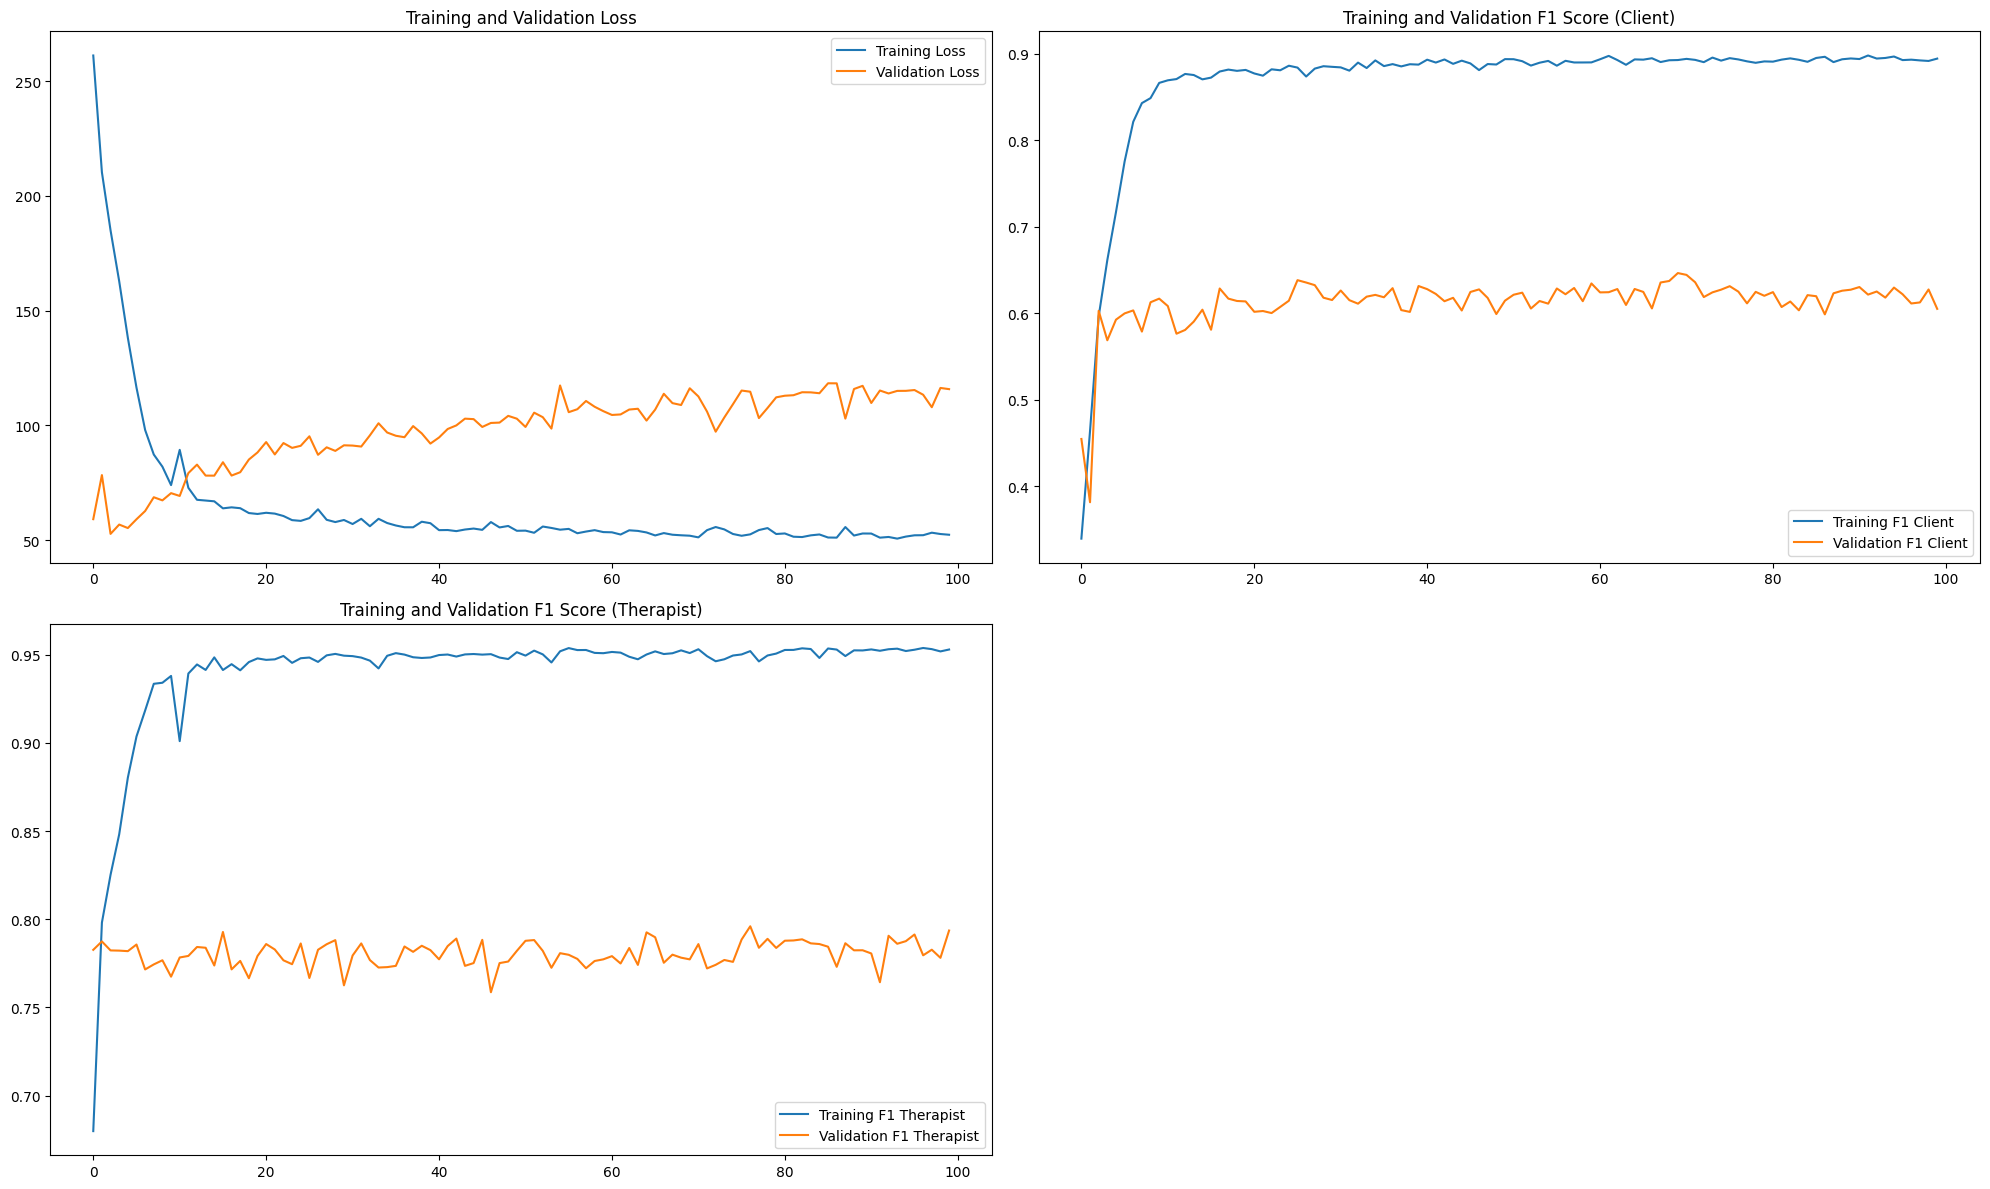

In [15]:
epochs_range = range(epochs)

plt.figure(figsize=(20, 12))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plot training and validation F1 scores for Client
plt.subplot(2, 2, 2)
plt.plot(epochs_range, training_f1_scores_client, label='Training F1 Client')
plt.plot(epochs_range, validation_f1_scores_client, label='Validation F1 Client')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Client)')

# Plot training and validation F1 scores for Therapist
plt.subplot(2, 2, 3)
plt.plot(epochs_range, training_f1_scores_therapist, label='Training F1 Therapist')
plt.plot(epochs_range, validation_f1_scores_therapist, label='Validation F1 Therapist')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Therapist)')

plt.tight_layout()
plt.show()

In [16]:
# Load the best model
model_client = model
model_client.load_state_dict(torch.load("best_mtl_model_roberta_client.pth"))
model_client.eval()

model_therapist = model
model_therapist.load_state_dict(torch.load("best_mtl_model_roberta_therapist.pth"))
model_therapist.eval()

# Final evaluation function
def evaluate_model(model, dataloader, task_name):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask, task_name=task_name)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluate for both tasks
labels_client, preds_client = evaluate_model(model_client, val_loader_client, "client")
labels_therapist, preds_therapist = evaluate_model(model_therapist, val_loader_therapist, "therapist")

# For client task:
print("\nFinal Classification Report (Client):")
print(classification_report(labels_client, preds_client, target_names=client_class_names))

# For therapist task:
print("\nFinal Classification Report (Therapist):")
print(classification_report(labels_therapist, preds_therapist, target_names=therapist_class_names))



Final Classification Report (Client):
              precision    recall  f1-score   support

     neutral       0.66      0.53      0.59       332
      change       0.78      0.82      0.80       786
     sustain       0.46      0.53      0.49       150

    accuracy                           0.71      1268
   macro avg       0.63      0.63      0.63      1268
weighted avg       0.71      0.71      0.71      1268


Final Classification Report (Therapist):
                 precision    recall  f1-score   support

       question       0.91      0.87      0.89       455
therapist_input       0.90      0.80      0.85       364
     reflection       0.71      0.82      0.76       282
          other       0.66      0.71      0.68       187

       accuracy                           0.82      1288
      macro avg       0.79      0.80      0.80      1288
   weighted avg       0.83      0.82      0.82      1288

